In [1]:
# Milestone 5 - II - Fix on neural networks

# Initial data

In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pyarrow

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
os.listdir('/content/drive/My Drive/HAMLAB - private')

['A_components.parquet',
 'A_events.parquet',
 'B_events.parquet',
 'B_components.parquet',
 'C_events.parquet',
 'D_events.parquet',
 'C_components.parquet',
 'D_components.parquet',
 'M4 Neural network.ipynb']

In [6]:
path = '/content/drive/My Drive/HAMLAB - private'

try:
  df_a_events = pd.read_parquet(os.path.join(path, 'A_events.parquet'))
  df_a_components = pd.read_parquet(os.path.join(path, 'A_components.parquet'))
  df_b_events = pd.read_parquet(os.path.join(path, 'B_events.parquet'))
  df_b_components = pd.read_parquet(os.path.join(path, 'B_components.parquet'))
  df_c_events = pd.read_parquet(os.path.join(path, 'C_events.parquet'))
  df_c_components = pd.read_parquet(os.path.join(path, 'C_components.parquet'))
  df_d_events = pd.read_parquet(os.path.join(path, 'D_events.parquet'))
  df_d_components = pd.read_parquet(os.path.join(path, 'D_components.parquet'))

  print("Successfully loaded dataframes.")

except FileNotFoundError:
  print("One or more parquet files not found in the specified directory.")
except Exception as e:
  print(f"An error occurred: {e}")


Successfully loaded dataframes.


In [7]:
"""
df_a_events = pd.read_parquet("A_events.parquet")
df_a_components = pd.read_parquet("A_components.parquet")
df_b_events = pd.read_parquet("B_events.parquet")
df_b_components = pd.read_parquet("B_components.parquet")
"""

'\ndf_a_events = pd.read_parquet("A_events.parquet")\ndf_a_components = pd.read_parquet("A_components.parquet")\ndf_b_events = pd.read_parquet("B_events.parquet")\ndf_b_components = pd.read_parquet("B_components.parquet")\n'

In [8]:
def merge_events_components(events_df, components_df):
    # Drop common columns from events_df (except 'Attack ID')
    common_columns = set(events_df.columns) & set(components_df.columns)
    common_columns.discard("Attack ID")

    events_df_clean = events_df.drop(columns=common_columns)

    # Merge on 'Attack ID'
    merged_df = pd.merge(
        components_df,
        events_df_clean,
        on="Attack ID",
        how="inner"
    )

    return merged_df

In [9]:
df_a = merge_events_components(df_a_events, df_a_components)
df_b = merge_events_components(df_b_events, df_b_components)
df = pd.concat([df_a, df_b], ignore_index=True)

c_df = merge_events_components(df_c_events, df_c_components)
d_df = merge_events_components(df_d_events, df_d_components)

In [10]:
df.info()

c_df.info()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820091 entries, 0 to 1820090
Data columns (total 17 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   Attack ID            int64 
 1   Detect count         int64 
 2   Card                 object
 3   Victim IP            object
 4   Port number          int64 
 5   Attack code          object
 6   Significant flag     int64 
 7   Packet speed         int64 
 8   Data speed           int64 
 9   Avg packet len       int64 
 10  Source IP count      int64 
 11  Time                 object
 12  Avg source IP count  int64 
 13  Start time           object
 14  End time             object
 15  Whitelist flag       int64 
 16  Type                 object
dtypes: int64(10), object(7)
memory usage: 236.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247266 entries, 0 to 1247265
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------   

# Data preparation

In [11]:
def drop_columns(dataframe, columns_to_drop=None):
    if columns_to_drop is None:
        columns_to_drop = ["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"]

    return dataframe.drop(columns=columns_to_drop, errors='ignore')

def filter_invalid_times(dataframe, time_columns=None):
    if time_columns is None:
        time_columns = ["Start time", "End time"]

    # filter mask for vald rows
    mask = True
    for col in time_columns:
        mask &= (dataframe[col] != "0")

    return dataframe[mask]

def extract_time_features(
    dataframe: pd.DataFrame,
    start_time_col: str = "Start time",
    end_time_col: str = "End time"
) -> pd.DataFrame:

    # date to time conversion
    for col in [start_time_col, end_time_col]:
        dataframe[col] = pd.to_datetime(dataframe[col])

    # extract time features
    time_features = {
        "hour": "hour",
        "weekday": "weekday",
        "dayofyear": "dayofyear"
    }

    # add features to Start and End columns
    for time_col, suffix in zip([start_time_col, end_time_col], ["Start", "End"]):
        for feature, method in time_features.items():
            new_col_name = f"{suffix}_time_{feature}"
            dataframe[new_col_name] = getattr(dataframe[time_col].dt, method)

    return dataframe

def sin_cos_encode(series: pd.Series, period: int) -> tuple[pd.Series, pd.Series]:
    radians = 2 * np.pi * series / period
    return np.sin(radians), np.cos(radians)

def add_cyclical_features(
    dataframe: pd.DataFrame,
    time_prefixes: list = ["Start_time", "End_time"],
    features: list = ["hour", "weekday", "dayofyear"],
    periods: list = [24, 7, 365]
) -> pd.DataFrame:
    for prefix in time_prefixes:
        for feature, period in zip(features, periods):
            col_name = f"{prefix}_{feature}"

            try:
                # generate sin and cos columns
                sin_col = f"{col_name}_sin"
                cos_col = f"{col_name}_cos"
                dataframe[sin_col], dataframe[cos_col] = sin_cos_encode(dataframe[col_name], period)
            except KeyError:
                raise ValueError(f"{col_name} oszlop nem található a DataFrame-ben!")

    return dataframe

def process_categorical_features(
    dataframe: pd.DataFrame,
    victim_ip_col: str = "Victim IP",
    type_col: str = "Type"
) -> pd.DataFrame:
   # get number from IP
    dataframe["Victim IP Number"] = (
        dataframe[victim_ip_col]
        .str.extract(r"IP_(\d+)")
        .astype(int)
    )

    # keep original type
    dataframe[f"{type_col}_Original"] = dataframe[type_col]

    # one-hot encoding
    dataframe = pd.get_dummies(
        dataframe,
        columns=[type_col],
        prefix=type_col
    )

    # restore original column name
    dataframe = dataframe.rename(
        columns={f"{type_col}_Original": type_col}
    )

    return dataframe

def transform_and_clean_data(
    dataframe: pd.DataFrame,
    rename_dict: dict = None,
    type_columns: list = None,
    type_mapping: dict = None
) -> pd.DataFrame:
    # rebane dictionary
    default_rename = {
        "Victim IP Number": "victim_ip",
        "Port number": "port_number",
        "Packet speed": "packet_speed",
        "Data speed": "data_speed",
        "Avg packet len": "packet_len",
        "Source IP count": "source_ip",
        "Start_time_hour_sin": "start_hour",
        "Start_time_weekday_sin": "start_weekday",
        "Start_time_dayofyear_sin": "start_dayofyear",
        "End_time_hour_sin": "end_hour",
        "End_time_weekday_sin": "end_weekday",
        "End_time_dayofyear_sin": "end_dayofyear",
        "Type_DDoS attack": "type_ddos",
        "Type_Normal traffic": "type_normal",
        "Type_Suspicious traffic": "type_sus"
    }

    default_type_cols = ["type_ddos", "type_sus", "type_normal"]
    default_type_map = {
        "type_ddos": "ddos",
        "type_sus": "sus",
        "type_normal": "normal"
    }

    # Apply params
    rename_dict = rename_dict or default_rename
    type_columns = type_columns or default_type_cols
    type_mapping = type_mapping or default_type_map

    # Rename columns
    df = dataframe.rename(columns=rename_dict, errors='ignore')

    # Select columns
    required_columns = [
        "victim_ip", "port_number", "packet_speed", "data_speed", "packet_len", "source_ip",
        "start_hour", "start_weekday", "start_dayofyear",
        "end_hour", "end_weekday", "end_dayofyear"
    ] + type_columns

    df = df.reindex(columns=required_columns, fill_value=0)

    # 3. Típus oszlop generálása
    if all(col in df.columns for col in type_columns):
        df["type"] = df[type_columns].idxmax(axis=1)
        df["type"] = df["type"].map(type_mapping)
        df = df.drop(columns=type_columns)
    else:
        missing = [col for col in type_columns if col not in df.columns]
        raise KeyError(f"Hiányzó típus oszlopok: {missing}")

    return df

In [12]:
df = drop_columns(df)
c_df = drop_columns(c_df)
d_df = drop_columns(d_df)

In [13]:
df = filter_invalid_times(df)
c_df = filter_invalid_times(c_df)
d_df = filter_invalid_times(d_df)

In [14]:
df = extract_time_features(df)
c_df = extract_time_features(c_df)
d_df = extract_time_features(d_df)

df = add_cyclical_features(df)
c_df = add_cyclical_features(c_df)
d_df = add_cyclical_features(d_df)


In [15]:
df = process_categorical_features(df)
c_df = process_categorical_features(c_df)
d_df = process_categorical_features(d_df)

In [16]:
df = transform_and_clean_data(df)
c_df = transform_and_clean_data(c_df)
d_df = transform_and_clean_data(d_df)

In [17]:
df.info()
c_df.info()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820085 entries, 0 to 1820090
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   victim_ip        int64  
 1   port_number      int64  
 2   packet_speed     int64  
 3   data_speed       int64  
 4   packet_len       int64  
 5   source_ip        int64  
 6   start_hour       float64
 7   start_weekday    float64
 8   start_dayofyear  float64
 9   end_hour         float64
 10  end_weekday      float64
 11  end_dayofyear    float64
 12  type             object 
dtypes: float64(6), int64(6), object(1)
memory usage: 194.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247266 entries, 0 to 1247265
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   victim_ip        1247266 non-null  int64  
 1   port_number      1247266 non-null  int64  
 2   packet_speed     1247266 non-null  int64  
 3   data_speed       124

In [18]:
df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,1,4500,55600,73,1383,6,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
1,2,4500,63500,90,1506,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
2,3,1200,59700,79,1399,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
3,3,1200,65700,86,1399,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
4,2,4500,59500,85,1486,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal


In [19]:
c_df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,60532,0,51800,74,1506,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
1,67501,0,68000,91,1404,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
2,60532,0,53700,76,1494,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
3,60976,0,81600,100,1287,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
4,60976,64755,58200,71,1281,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal


In [20]:
d_df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,50106,51820,163300,82,808,2,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
1,50106,51820,164500,83,825,2,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
2,50106,51820,118200,90,808,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
3,84625,0,86800,103,1236,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
4,84625,59644,118100,140,1223,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal


# Hyper-parameter optimazition

# New implementation with classic Pytorch to support hyper-parameter tuning with Optuna

## Pytorch implementation

In [21]:
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

class DDoSFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super(DDoSFFNN, self).__init__()
        layers = []
        in_dim = input_dim

        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = h_dim

        layers.append(nn.Linear(in_dim, 3))  # 3 kimeneti neuron (multiclass)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [22]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

class DDoSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class DDoSDataModule:
    def __init__(self, df, test_df=None, batch_size=64, test_size=0.2, val_size=0.1):
        self.df = df.copy()
        self.test_df = test_df
        self.batch_size = batch_size
        self.test_size = test_size
        self.val_size = val_size

        self.scaler = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self._prepare_data()

    def _prepare_data(self):
        df = self.df.copy()

        # detect target
        target_col = next((col for col in df.columns if col.strip().lower() == "type"), None)
        if target_col is None:
            raise ValueError("A 'type' vagy 'Type' oszlop nem található a bemeneti DataFrame-ben.")

        # encode tcategorical column
        for col in df.select_dtypes(include='object').columns:
            if col != target_col:
                df[col] = LabelEncoder().fit_transform(df[col].astype(str))

        # target cndode
        df[target_col] = self.label_encoder.fit_transform(df[target_col])

        # seperate target from feature
        drop_cols = [target_col]
        if 'Attack ID' in df.columns:
            drop_cols.append('Attack ID')
        X = df.drop(columns=drop_cols).values
        y = df[target_col].values

        # split training and temporary data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=self.test_size, stratify=y, random_state=42
        )

        if self.test_df is None:
            # split validation and test datas
            val_relative_size = self.val_size / (1 - self.test_size)
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
            )
        else:
            X_val, y_val = X_temp, y_temp

            test_df = self.test_df.copy()

            # target column in test df
            test_target_col = next((col for col in test_df.columns if col.strip().lower() == "type"), None)
            if test_target_col is None:
                raise ValueError("A 'type' vagy 'Type' oszlop nem található a teszt DataFrame-ben.")

            for col in test_df.select_dtypes(include='object').columns:
                if col != test_target_col:
                    test_df[col] = LabelEncoder().fit_transform(test_df[col].astype(str))

            test_df[test_target_col] = self.label_encoder.transform(test_df[test_target_col])

            drop_test_cols = [test_target_col]
            if 'Attack ID' in test_df.columns:
                drop_test_cols.append('Attack ID')
            X_test = test_df.drop(columns=drop_test_cols).values
            y_test = test_df[test_target_col].values

        # normalization
        self.scaler.fit(X_train)
        self.X_train = self.scaler.transform(X_train)
        self.X_val = self.scaler.transform(X_val)
        self.X_test = self.scaler.transform(X_test)

        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

    def setup(self, stage=None):
      self.train_dataset = DDoSDataset(self.X_train, self.y_train)
      self.val_dataset = DDoSDataset(self.X_val, self.y_val)
      self.test_dataset = DDoSDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(DDoSDataset(self.X_train, self.y_train), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(DDoSDataset(self.X_val, self.y_val), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(DDoSDataset(self.X_test, self.y_test), batch_size=self.batch_size, shuffle=False)


### Test the neural netowrk

In [23]:
x_test = torch.randn(5, 12)  # 5 sameple, 12 feature
y_test = torch.tensor([0, 1, 2, 0, 1], dtype=torch.long)

model = DDoSFFNN(input_dim=12, hidden_dims=[64, 32], dropout_rate=0.3)

outputs = model(x_test)

print(f"Model output shape: {outputs.shape}")  #waiting for 5,3

softmax = nn.Softmax(dim=1)
probs = softmax(outputs)
preds = torch.argmax(probs, dim=1)

print(f"preduction: {preds.tolist()}")

criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, y_test)

print(f"loss value: {loss.item():.4f}")


Model output shape: torch.Size([5, 3])
preduction: [1, 0, 0, 1, 1]
loss value: 1.0797


In [24]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

def train_and_evaluate_with_pr_auc(model, datamodule, epochs=10, learning_rate=0.001):
    device = torch.device("cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = datamodule.train_dataloader()
    val_loader = datamodule.val_dataloader()
    test_loader = datamodule.test_dataloader()

    # training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())

        val_report = classification_report(val_targets, val_preds, output_dict=True, zero_division=0)
        val_acc = val_report["accuracy"]
        val_f1 = val_report["weighted avg"]["f1-score"]
        print(f"[{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # test
    model.eval()
    test_preds, test_targets = [], []
    all_outputs = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            all_outputs.append(outputs.cpu())
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(y_batch.cpu().numpy())

    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    all_outputs = torch.cat(all_outputs).numpy()

    y_score = all_outputs
    y_true_bin = label_binarize(test_targets, classes=[0, 1, 2])
    class_names = ["ddos", "normal", "suspicious"]

    # PR-AUC
    pr_aucs = []
    plt.figure(figsize=(8, 6))
    for i in range(3):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
        pr_aucs.append(ap)
        plt.plot(recall, precision, label=f"{class_names[i]} (PR-AUC = {ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve on each class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Reports
    report = classification_report(test_targets, test_preds, target_names=class_names, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(test_targets, test_preds)

    precision = [report[cls]["precision"] for cls in class_names]
    recall = [report[cls]["recall"] for cls in class_names]
    f1 = [report[cls]["f1-score"] for cls in class_names]

    # PRC/REC/F1
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    plt.bar(x - 0.2, precision, width=0.2, label='Precision')
    plt.bar(x, recall, width=0.2, label='Recall')
    plt.bar(x + 0.2, f1, width=0.2, label='F1-score')
    plt.xticks(x, class_names)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1-score on each class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Confusiotn mtx
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    print("\n Confusion mtx:")
    for i, true_class in enumerate(class_names):
        row = " | ".join(f"{conf_matrix[i, j]:7d}" for j in range(len(class_names)))
        print(f"{true_class.title():<12}: {row}")

    print("\n summary:")
    for i, cls in enumerate(class_names):
        print(f" - {cls.title():<10} | Precision: {precision[i]:.2f} | Recall: {recall[i]:.2f} | F1: {f1[i]:.2f} | PR-AUC: {pr_aucs[i]:.2f}")


# Learning and eval C dataset


[1/10] Loss: 0.3089 | Val Acc: 0.9065 | F1: 0.8960
[2/10] Loss: 0.2537 | Val Acc: 0.9074 | F1: 0.8966
[3/10] Loss: 0.2401 | Val Acc: 0.9106 | F1: 0.9003
[4/10] Loss: 0.2318 | Val Acc: 0.9204 | F1: 0.9137
[5/10] Loss: 0.2257 | Val Acc: 0.9230 | F1: 0.9159
[6/10] Loss: 0.2211 | Val Acc: 0.9296 | F1: 0.9244
[7/10] Loss: 0.2165 | Val Acc: 0.9258 | F1: 0.9194
[8/10] Loss: 0.2138 | Val Acc: 0.9299 | F1: 0.9238
[9/10] Loss: 0.2115 | Val Acc: 0.9286 | F1: 0.9235
[10/10] Loss: 0.2088 | Val Acc: 0.9295 | F1: 0.9238


<ipython-input-25-132e58f91f6e>:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


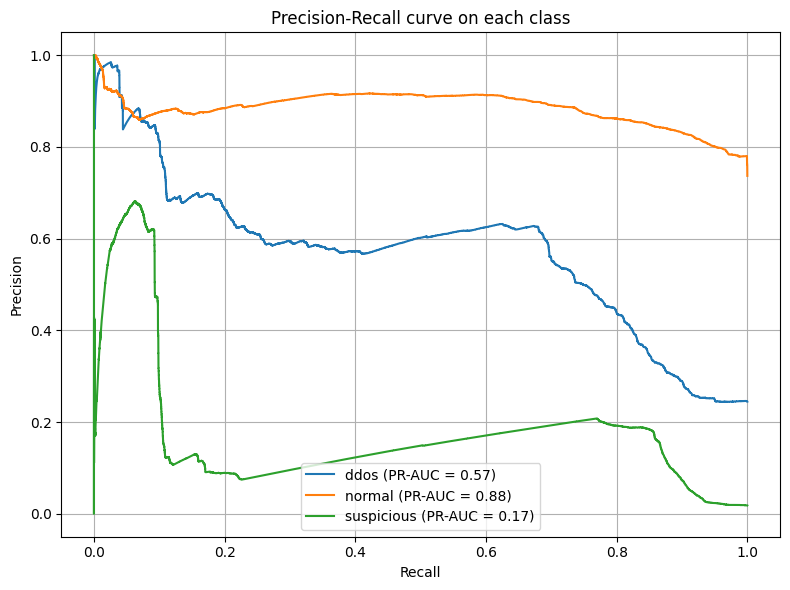

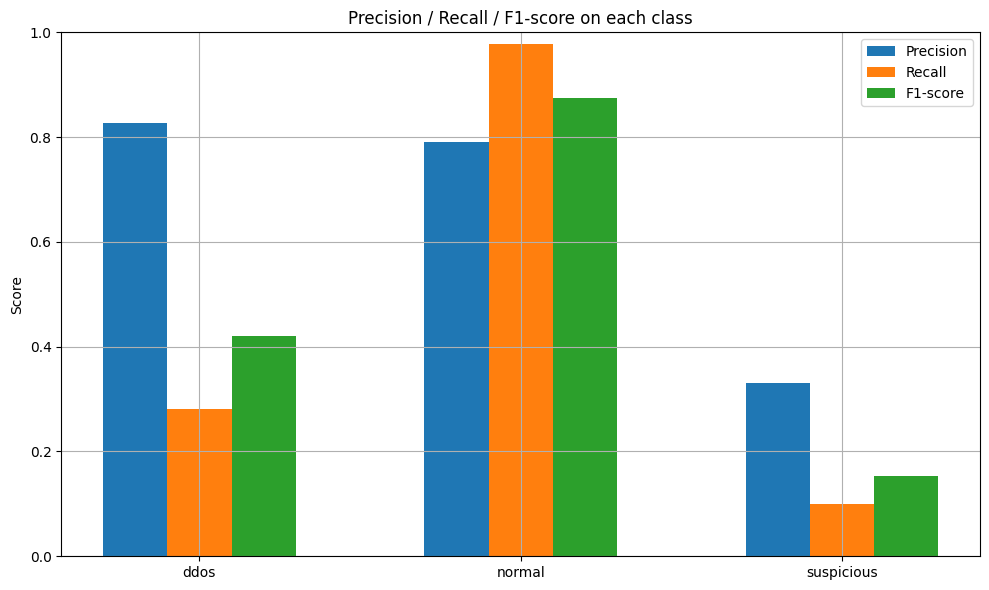

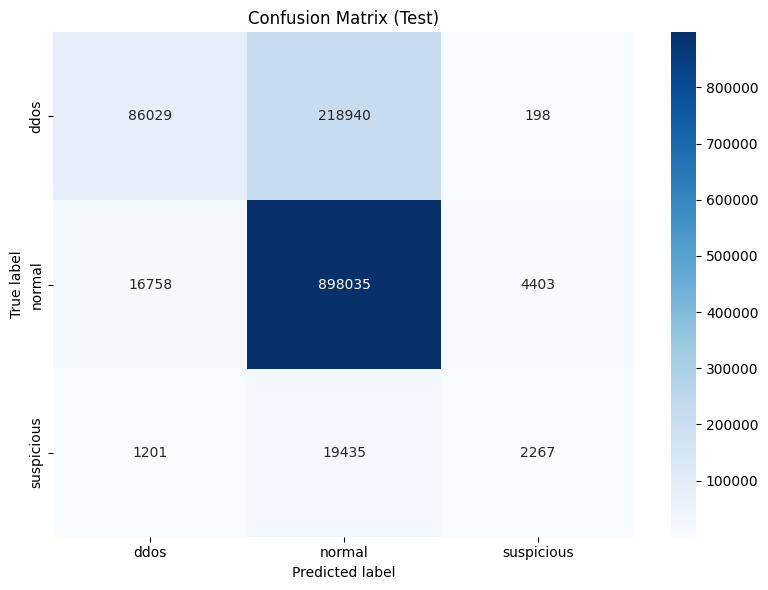


 Confusion mtx:
Ddos        :   86029 |  218940 |     198
Normal      :   16758 |  898035 |    4403
Suspicious  :    1201 |   19435 |    2267

 summary:
 - Ddos       | Precision: 0.83 | Recall: 0.28 | F1: 0.42 | PR-AUC: 0.57
 - Normal     | Precision: 0.79 | Recall: 0.98 | F1: 0.87 | PR-AUC: 0.88
 - Suspicious | Precision: 0.33 | Recall: 0.10 | F1: 0.15 | PR-AUC: 0.17


In [26]:
datamodule_c = DDoSDataModule(df, test_df=c_df, batch_size=64)

model = DDoSFFNN(
    input_dim=datamodule_c.X_train.shape[1],
    hidden_dims=[128, 64],
    dropout_rate=0.3
)

train_and_evaluate_with_pr_auc(model, datamodule_c, epochs=10, learning_rate=0.001)


[1/10] Loss: 0.3063 | Val Acc: 0.9055 | F1: 0.8958
[2/10] Loss: 0.2493 | Val Acc: 0.9146 | F1: 0.9088
[3/10] Loss: 0.2368 | Val Acc: 0.9142 | F1: 0.9053
[4/10] Loss: 0.2284 | Val Acc: 0.9196 | F1: 0.9133
[5/10] Loss: 0.2224 | Val Acc: 0.9228 | F1: 0.9167
[6/10] Loss: 0.2175 | Val Acc: 0.9300 | F1: 0.9266
[7/10] Loss: 0.2133 | Val Acc: 0.9282 | F1: 0.9236
[8/10] Loss: 0.2104 | Val Acc: 0.9243 | F1: 0.9200
[9/10] Loss: 0.2078 | Val Acc: 0.9272 | F1: 0.9217
[10/10] Loss: 0.2054 | Val Acc: 0.9331 | F1: 0.9292


<ipython-input-25-132e58f91f6e>:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


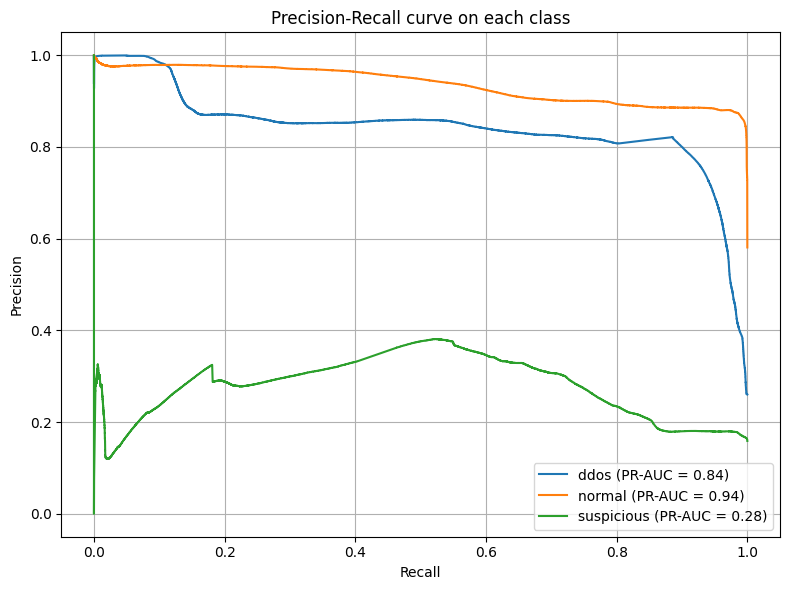

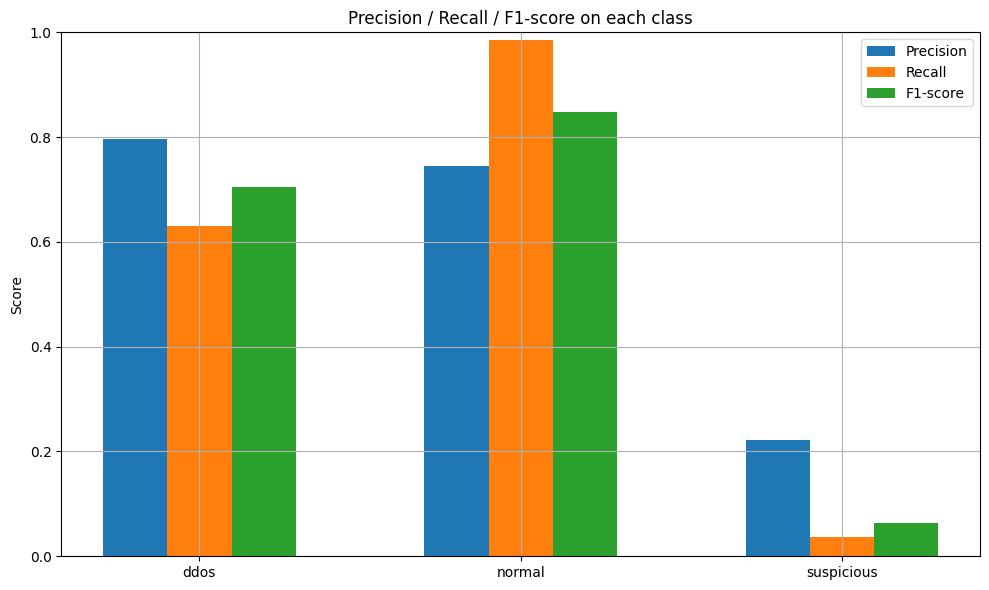

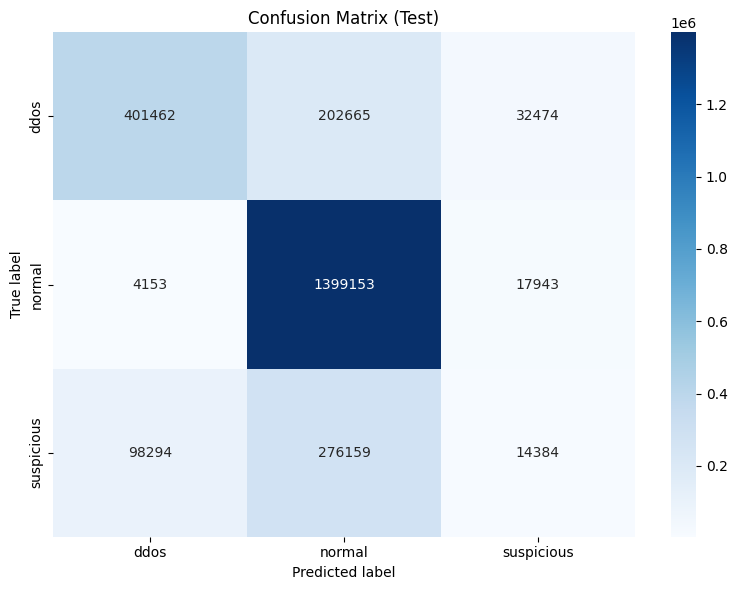


 Confusion mtx:
Ddos        :  401462 |  202665 |   32474
Normal      :    4153 | 1399153 |   17943
Suspicious  :   98294 |  276159 |   14384

 summary:
 - Ddos       | Precision: 0.80 | Recall: 0.63 | F1: 0.70 | PR-AUC: 0.84
 - Normal     | Precision: 0.75 | Recall: 0.98 | F1: 0.85 | PR-AUC: 0.94
 - Suspicious | Precision: 0.22 | Recall: 0.04 | F1: 0.06 | PR-AUC: 0.28


In [27]:
datamodule_d = DDoSDataModule(df, test_df=d_df, batch_size=64)

model = DDoSFFNN(
    input_dim=datamodule_d.X_train.shape[1],
    hidden_dims=[128, 64],
    dropout_rate=0.3
)

train_and_evaluate_with_pr_auc(model, datamodule_d, epochs=10, learning_rate=0.001)


# FIX L1,L2, SMOTE stb.

In [29]:
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    f1_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

class DDoSFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout_rate=0.2):
        super(DDoSFFNN, self).__init__()
        layers = []
        in_dim = input_dim

        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = h_dim

        layers.append(nn.Linear(in_dim, 3))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class DDoSDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DDoSDataModule:
    def __init__(self, df, test_df=None, batch_size=64, test_size=0.2, val_size=0.1):
        self.df = df.copy()
        self.test_df = test_df
        self.batch_size = batch_size
        self.test_size = test_size
        self.val_size = val_size
        self.scaler = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self._prepare_data()

    def _prepare_data(self):
        df = self.df.copy()
        target_col = next((col for col in df.columns if col.strip().lower() == "type"), None)
        if target_col is None:
            raise ValueError("no type column")

        for col in df.select_dtypes(include='object').columns:
            if col != target_col:
                df[col] = LabelEncoder().fit_transform(df[col].astype(str))

        df[target_col] = self.label_encoder.fit_transform(df[target_col])

        drop_cols = [target_col]
        if 'Attack ID' in df.columns:
            drop_cols.append('Attack ID')
        X = df.drop(columns=drop_cols).values
        y = df[target_col].values

        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=self.test_size, stratify=y, random_state=42
        )

        if self.test_df is None:
            val_relative_size = self.val_size / (1 - self.test_size)
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
            )
        else:
            X_val, y_val = X_temp, y_temp

            test_df = self.test_df.copy()
            test_target_col = next((col for col in test_df.columns if col.strip().lower() == "type"), None)
            if test_target_col is None:
                raise ValueError("no type columns")

            for col in test_df.select_dtypes(include='object').columns:
                if col != test_target_col:
                    test_df[col] = LabelEncoder().fit_transform(test_df[col].astype(str))

            test_df[test_target_col] = self.label_encoder.transform(test_df[test_target_col])

            drop_test_cols = [test_target_col]
            if 'Attack ID' in test_df.columns:
                drop_test_cols.append('Attack ID')
            X_test = test_df.drop(columns=drop_test_cols).values
            y_test = test_df[test_target_col].values

        self.scaler.fit(X_train)
        self.X_train = self.scaler.transform(X_train)
        self.X_val = self.scaler.transform(X_val)
        self.X_test = self.scaler.transform(X_test)

        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

    def setup(self, stage=None):
        self.train_dataset = DDoSDataset(self.X_train, self.y_train)
        self.val_dataset = DDoSDataset(self.X_val, self.y_val)
        self.test_dataset = DDoSDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


def train_and_evaluate_with_pr_auc(model, datamodule, epochs=5, learning_rate=0.0005, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    sm = SMOTE(sampling_strategy={2: max(np.bincount(datamodule.y_train))}, random_state=42)
    X_resampled, y_resampled = sm.fit_resample(datamodule.X_train, datamodule.y_train)
    datamodule.X_train = X_resampled
    datamodule.y_train = y_resampled
    datamodule.setup(stage='fit')

    train_loader = datamodule.train_dataloader()
    val_loader = datamodule.val_dataloader()
    test_loader = datamodule.test_dataloader()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_f1 = 0
    wait = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())

        val_report = classification_report(val_targets, val_preds, output_dict=True, zero_division=0)
        val_acc = val_report["accuracy"]
        val_f1 = val_report["weighted avg"]["f1-score"]
        print(f"[{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f" Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
                break

    # test
    model.eval()
    test_preds, test_targets = [], []
    all_outputs = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            all_outputs.append(outputs.cpu())
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(y_batch.cpu().numpy())

    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    all_outputs = torch.cat(all_outputs).numpy()

    y_score = all_outputs
    y_true_bin = label_binarize(test_targets, classes=[0, 1, 2])
    class_names = ["ddos", "normal", "suspicious"]

    # PR-AUC
    pr_aucs = []
    plt.figure(figsize=(8, 6))
    for i in range(3):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
        pr_aucs.append(ap)
        plt.plot(recall, precision, label=f"{class_names[i]} (PR-AUC = {ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve on each class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Reports
    report = classification_report(test_targets, test_preds, target_names=class_names, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(test_targets, test_preds)

    precision = [report[cls]["precision"] for cls in class_names]
    recall = [report[cls]["recall"] for cls in class_names]
    f1 = [report[cls]["f1-score"] for cls in class_names]

    # PRC/REC/F1
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    plt.bar(x - 0.2, precision, width=0.2, label='Precision')
    plt.bar(x, recall, width=0.2, label='Recall')
    plt.bar(x + 0.2, f1, width=0.2, label='F1-score')
    plt.xticks(x, class_names)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1-score on each class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Confusiotn mtx
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    print("\n Confusion mtx:")
    for i, true_class in enumerate(class_names):
        row = " | ".join(f"{conf_matrix[i, j]:7d}" for j in range(len(class_names)))
        print(f"{true_class.title():<12}: {row}")

    print("\n summary:")
    for i, cls in enumerate(class_names):
        print(f" - {cls.title():<10} | Precision: {precision[i]:.2f} | Recall: {recall[i]:.2f} | F1: {f1[i]:.2f} | PR-AUC: {pr_aucs[i]:.2f}")


[1/5] Loss: 0.2919 | Val Acc: 0.8808 | F1: 0.8893
[2/5] Loss: 0.2119 | Val Acc: 0.8990 | F1: 0.9082
[3/5] Loss: 0.1890 | Val Acc: 0.9157 | F1: 0.9234
[4/5] Loss: 0.1750 | Val Acc: 0.9175 | F1: 0.9249
[5/5] Loss: 0.1651 | Val Acc: 0.9240 | F1: 0.9313


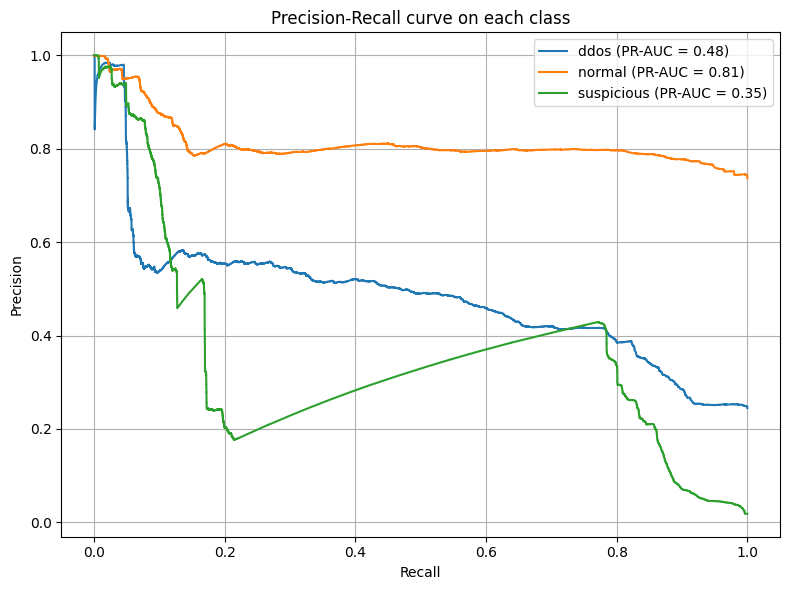

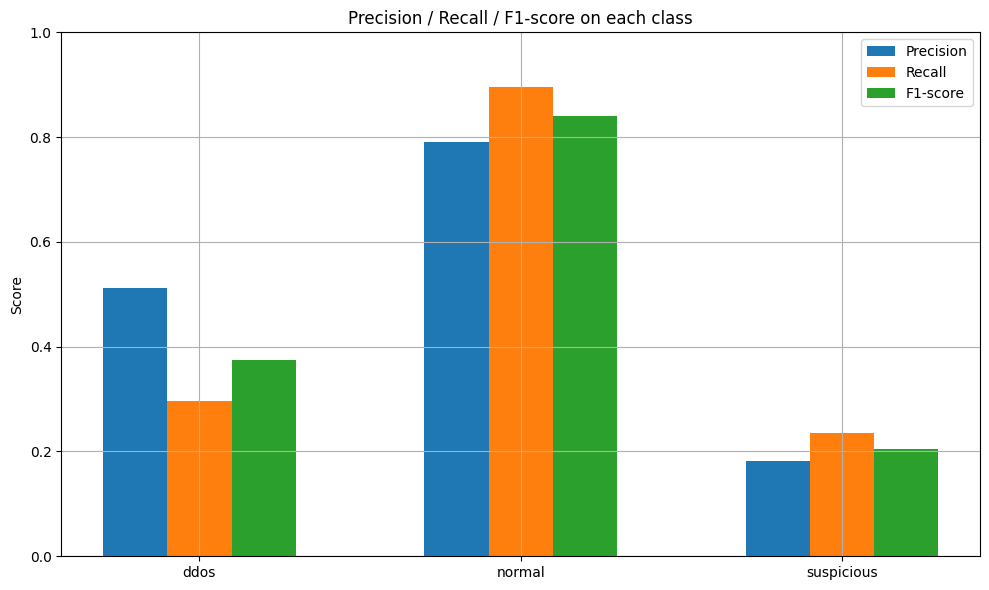

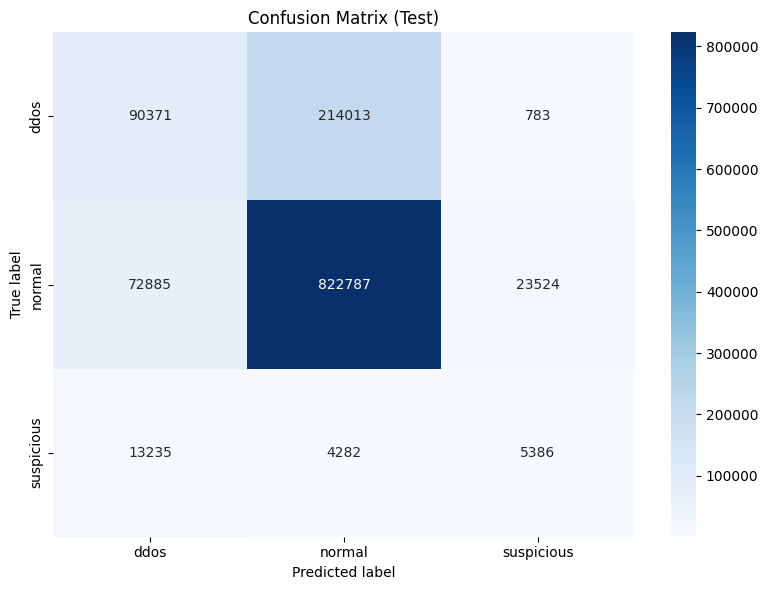


 Confusion mtx:
Ddos        :   90371 |  214013 |     783
Normal      :   72885 |  822787 |   23524
Suspicious  :   13235 |    4282 |    5386

 summary:
 - Ddos       | Precision: 0.51 | Recall: 0.30 | F1: 0.38 | PR-AUC: 0.48
 - Normal     | Precision: 0.79 | Recall: 0.90 | F1: 0.84 | PR-AUC: 0.81
 - Suspicious | Precision: 0.18 | Recall: 0.24 | F1: 0.20 | PR-AUC: 0.35


In [30]:
datamodule_c = DDoSDataModule(df, test_df=c_df, batch_size=64)
model = DDoSFFNN(input_dim=datamodule_c.X_train.shape[1], hidden_dims=[256, 128], dropout_rate=0.2)
train_and_evaluate_with_pr_auc(model, datamodule_c)

[1/5] Loss: 0.2937 | Val Acc: 0.8806 | F1: 0.8892
[2/5] Loss: 0.2168 | Val Acc: 0.8929 | F1: 0.9019
[3/5] Loss: 0.1955 | Val Acc: 0.9057 | F1: 0.9134
[4/5] Loss: 0.1810 | Val Acc: 0.9092 | F1: 0.9180
[5/5] Loss: 0.1709 | Val Acc: 0.9128 | F1: 0.9215


<ipython-input-29-65c27e9fcaa6>:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


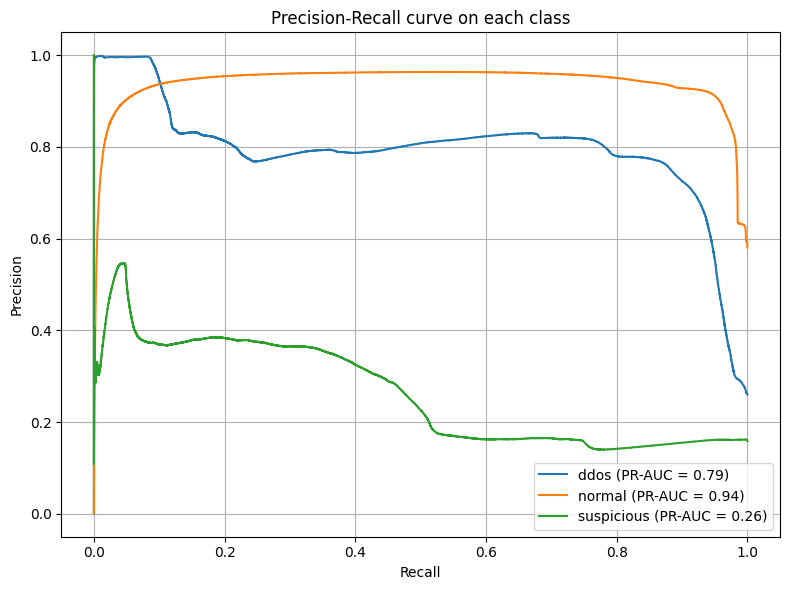

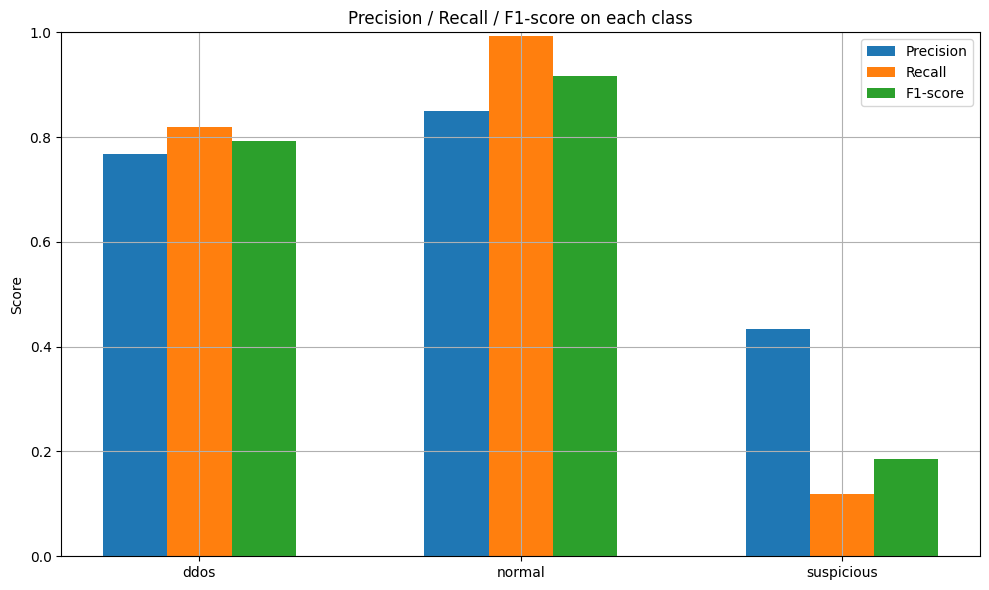

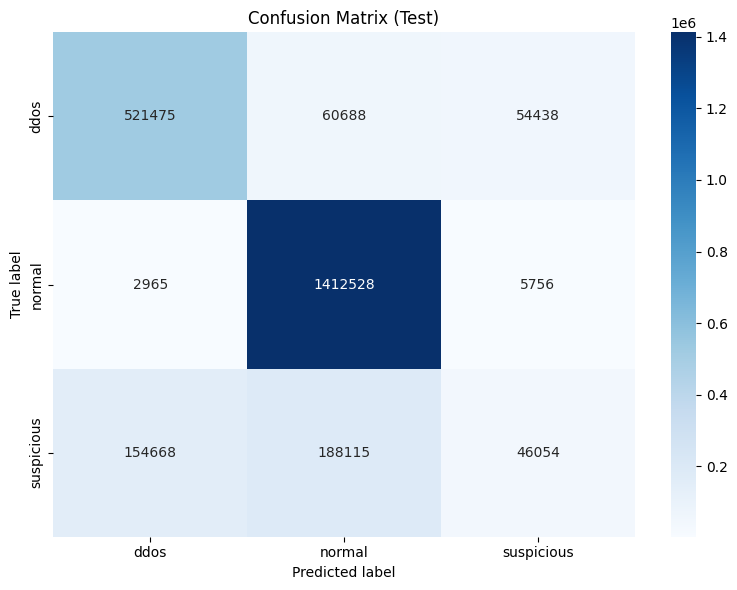


 Confusion mtx:
Ddos        :  521475 |   60688 |   54438
Normal      :    2965 | 1412528 |    5756
Suspicious  :  154668 |  188115 |   46054

 summary:
 - Ddos       | Precision: 0.77 | Recall: 0.82 | F1: 0.79 | PR-AUC: 0.79
 - Normal     | Precision: 0.85 | Recall: 0.99 | F1: 0.92 | PR-AUC: 0.94
 - Suspicious | Precision: 0.43 | Recall: 0.12 | F1: 0.19 | PR-AUC: 0.26


In [32]:
datamodule_d = DDoSDataModule(df, test_df=d_df, batch_size=64)
model = DDoSFFNN(input_dim=datamodule_d.X_train.shape[1], hidden_dims=[256, 128], dropout_rate=0.2)
train_and_evaluate_with_pr_auc(model, datamodule_d)